In [1]:

import requests
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal, matrix_normal, multivariate_t
import networkx as nx
import sys
sys.path.insert(0, 'C:/Users/ragna/Documents/Code/DyGraph')
sys.path.insert(0, 'C:/Users/ragna/Documents/Code/DyGraph/src')
import DyGraph as dg
import CovReg as cr
import matplotlib.pyplot as plt
import tqdm
import scipy
from scipy.optimize import minimize
from sklearn import linear_model

from sklearn.metrics.pairwise import rbf_kernel
import pickle


In [2]:
def calc_shapley_value(B,X=None, Sigma = None):
    if Sigma is None:
        Sigma = np.cov(X.T)
    
    r = Sigma.shape[0]
    val_y = np.dot(B, Sigma).dot(B.T)

    d = val_y.shape[0]
    shapleys = np.zeros((int(d*(d+1)/2), r))
    index = np.arange(r)


    cnt=0
    for i in range(d):
        for j in range(i,d):
            for k in range(r):
                t1 = B[i,k]*B[j,k]*Sigma[k,k]
                t2 = 0.5*np.sum(B[i,index != k]*B[j,k]*Sigma[k,index != k])
                t3 = 0.5*np.sum(B[j,index != k]*B[i,k]*Sigma[k,index != k])
                shapleys[cnt,k] = t1+t2+t3
            cnt+=1

    return shapleys

In [ ]:
def lasso_objective(param, X, Y,Psi_inv, d,r, alpha, Z1,Z2, kappa, const)->tuple:
    """"
    Objective and gradient to pass into the L-BFGS-B solver to solve the lasso problem.
    """

    C = np.reshape(param[:r*d]-param[r*d:],(d,r))
    
    obj =  np.trace(np.dot((Y- np.dot(X,C.T)).T,(Y- np.dot(X,C.T))).dot(Psi_inv)) + alpha*param.sum() + const*0.5*kappa*np.linalg.norm(C-Z1-Z2) ** 2
    t_0 = Y.T-np.dot(C,X.T)

    grad = (-0.5*np.dot(t_0,X) + const*kappa*(C-Z1-Z2)).flatten()[:d*r]
    return obj, np.concatenate((grad + alpha , - grad + alpha ), axis=None)



def dynamic_covreg(Y, X, n_t, alpha, kappa):

    n = X.shape[0]
    d = Y.shape[1]
    r = X.shape[1]

    rho = n_t
    alpha = alpha*n_t
    kappa = kappa*n_t

    Y_tilde = np.vstack((Y, np.zeros((n,d))))

    T = int(n/n_t)

    C = np.ones((T, d, r))

    U1 = np.ones((T, d, r))
    U2 = np.ones((T, d, r))

    Z1 = np.zeros((T, d, r))
    Z2 = np.zeros((T, d, r))

    

    Psi_pre_inv = np.identity(d)

    for t in range(T):
        C_t = C[t].copy()
        X_t = X[t*n_t:(t+1)*n_t].copy()
        Y_t = Y[t*n_t:(t+1)*n_t].copy()

        # E -step
        if t == 0:
            m = np.random.normal(size = n_t)
            v = np.ones(n_t)
        else:
            for i in range(n_t):
                v[i] = (1+np.dot(X_t[i].T, C_t.T).dot(Psi_pre_inv).dot(C_t).dot(X_t[i])) ** (-1)
                m[i] = v[i]*np.dot((Y_t[i]-0).T,Psi_pre_inv).dot(C_t).dot(X_t[i])

        X_tilde =  np.vstack((m[:,np.newaxis]*X,v[:,np.newaxis]*X))
        # M -step
        
        if (t == 0) or (t == T-1):
            const = 1.0
        else:
            const = 2.0
        out = minimize(lasso_objective, C_vec, args = (X_tilde, Y_tilde, np.identity(d),d,r, alpha, Z1,Z2, kappa, const), method='L-BFGS-B', jac=True, bounds = [(0,None)]*(2*r*d))
        C_vec = out.x
        C = np.reshape(out.x[:(r)*d] - out.x[(r)*d:], (d,r))



        








# Analyze Cov regression experiment

In [3]:
#with open(f'C:/Users/ragna/Documents/Code/DyGraph/CovRegressionPaper/data_sim/shapley_less.pkl', 'rb') as handle:
with open(f'./data_sim/shapley_simple_psi0.1.pkl', 'rb') as handle:
    shap_data = pickle.load(handle)
shap_data.keys()

dict_keys(['liks_dict', 'nr_param_dict', 'B_est', 'B_true', 'Ys_dict_cov', 'Xs_dict'])

In [4]:
# alphas = shap_data['alphas']
# ns = shap_data['ns']
# rs = shap_data['rs']
# ds = shap_data['ds']
# value_function_cov_dict = shap_data['value_function_cov_dict']
# value_function_meancov_dict = shap_data['value_function_meancov_dict']
# B_dict_cov = shap_data['B_dict_cov']
# B_dict_cov_psi = shap_data['B_dict_cov_psi']
# B_dict_meancov = shap_data['B_dict_meancov']
# B_dict_true = shap_data['B_dict_true']
# val_y_true = shap_data['val_y_true']
# Psi_dict_cov = shap_data['Psi_dict_cov']
# Psi_dict_meancov = shap_data['Psi_dict_meancov']
# Xs_dict = shap_data['Xs_dict']
# Y_cov = shap_data['Ys_dict_cov']
# Y_meancov = shap_data['Ys_dict_meancov']

# lik_cov_dict  = shap_data['lik_cov_dict']
# lik_meancov_dict  = shap_data['lik_meancov_dict']
# lik_cov_psi_dict  = shap_data['lik_cov_psi_dict']
# lik_meancov_psi_dict  = shap_data['lik_meancov_psi_dict']

# nr_param_cov_dict  = shap_data['nr_param_cov_dict']
# nr_param_meancov_dict  = shap_data['nr_param_meancov_dict']
# nr_param_cov_psi_dict  = shap_data['nr_param_cov_psi_dict']
# nr_param_meancov_psi_dict  = shap_data['nr_param_meancov_psi_dict']


# colors = ['blue', 'orange', 'red', 'green', 'purple']  # colors for number of observation distiction

In [4]:
# test parameters
ns = [100, 500,1000]
rs = [5, 10, 20, 50, 100]
ds = [10]
alphas = np.concatenate(([0], np.logspace(-2,0, 20)))

rnd = np.random.RandomState(42)


        

# Storetrue data and coef
B_dict_true = dict()
A_dict_true = dict()
Xs_dict = dict()
Ys_dict_cov = dict()
Ys_dict_meancov = dict()






pbar = tqdm.tqdm(total = len(alphas)*len(ns)*len(ds)*len(rs), position = 1)
rnd = np.random.RandomState(42)

Xs_dict = {str(r): [] for r in rs}
for r in rs:
    Xs_dict[str(r)] = rnd.normal(loc = 0, scale = 1, size = (np.max(ns),r))


# Generate coef matrix
for r in rs:
    for d in ds:
        B_true = rnd.normal(loc = 0, scale = 1, size = (d,r))
        B_true[np.abs(B_true)<0.8] = 0
        B_dict_true[str(r) + '_'+str(d)] = B_true
        A_true = rnd.normal(loc = 0, scale = 1, size = (d,r))
        A_true = B_true*(rnd.uniform(size = (d,r) ) <0.6)
        A_dict_true[str(r) + '_'+str(d)] = A_true

# Generate observations

for r in rs:
    for d in ds:
        B_tmp = B_dict_true[str(r) + '_'+str(d)].copy()
        A_tmp = A_dict_true[str(r) + '_'+str(d)].copy()

        X = Xs_dict[str(r)].copy()
        gamma = rnd.normal(loc = 0, scale = 1, size = (np.max(ns)))
        epsilon = rnd.normal(loc = 0, scale = 0.1, size = (np.max(ns),d))

        Y_cov = gamma[:, np.newaxis]*np.dot(X, B_tmp.T) + epsilon
        Ys_dict_cov[str(r) + '_'+str(d)] = Y_cov.copy()


        Y_meancov = np.dot(X, A_tmp.T) + gamma[:, np.newaxis]*np.dot(X, B_tmp.T) + epsilon
        Ys_dict_meancov[str(r) + '_'+str(d)] = Y_meancov.copy()

In [5]:
r = 100
x = Xs_dict[str(r)][:500]
y = Ys_dict_cov[str(r) + '_'+str(d)][:500]
cov = cr.CovReg( Y = y, alpha =  0.01, max_iter = 50, tol = 1e-6)
cov.fit_hoff_b_only(X2 = x, verbose = False)
cov.marg_lik(X2 = x)

KeyboardInterrupt: 

In [42]:
r = 100
for alpha in [0, 0.01, 0.1, 0.5, 1]:
    x = Xs_dict[str(r)][:]
    y = Ys_dict_cov[str(r) + '_'+str(d)][:]
    cov = cr.CovReg( Y = y, alpha = alpha, max_iter = 100, tol = 1e-6)
    cov.fit_hoff_b_only(X2 = x, verbose = False)
    print(cov.marg_lik(X2 = x))

(31733.49059701235, 1000)
(14960.774918926727, 979)
(6010.510059370601, 421)
(18222.65328954483, 421)


C:\Users/ragna/Documents/Code/DyGraph/src\CovReg\covreg.py:171: RuntimeWarning: invalid value encountered in scalar divide
  tol_i = np.linalg.norm(C-C_pre)/np.linalg.norm(C_pre)


(45350.25655828336, 0)


In [8]:
alphas = np.concatenate(([0], np.logspace(-4,0.5, 60)))

In [6]:
shap_data.keys()

dict_keys(['liks_dict', 'nr_param_dict', 'B_est', 'B_true', 'Ys_dict_cov', 'Xs_dict'])

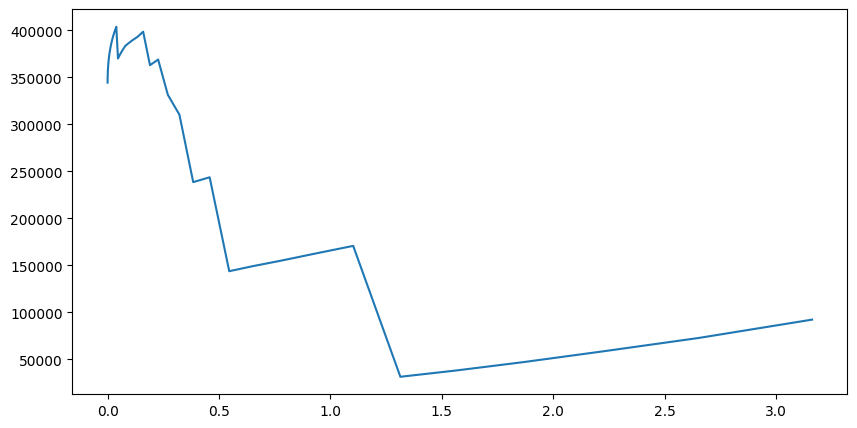

In [36]:
fig, ax = plt.subplots(1,1, figsize = (10,5))

# ax.plot(alphas,shap_data['liks_dict'][50][1000]+shap_data['nr_param_dict'][50][1000])
# ax.set_xlim((0,0.2))
# ax.set_ylim((22500, 25000))


# ax.plot(alphas,shap_data0['liks_dict'][50][500]+shap_data['nr_param_dict'][50][500])
# ax.set_xlim((0,0.2))
#ax.set_ylim((3000, 10000))

ax.plot(alphas,shap_data['liks_dict'][50][1000]+shap_data['nr_param_dict'][50][1000])
#ax.set_xlim((0,0.2))

In [26]:
alphas,shap_data['liks_dict'][20][500]+shap_data['nr_param_dict'][20][500]

(array([0.00000000e+00, 1.00000000e-04, 1.19198609e-04, 1.42083083e-04,
        1.69361058e-04, 2.01876025e-04, 2.40633414e-04, 2.86831681e-04,
        3.41899374e-04, 4.07539297e-04, 4.85781172e-04, 5.79044398e-04,
        6.90212866e-04, 8.22724134e-04, 9.80675722e-04, 1.16895182e-03,
        1.39337430e-03, 1.66088278e-03, 1.97974917e-03, 2.35983347e-03,
        2.81288866e-03, 3.35292415e-03, 3.99663894e-03, 4.76393801e-03,
        5.67854783e-03, 6.76875001e-03, 8.06825584e-03, 9.61724871e-03,
        1.14636267e-02, 1.36644835e-02, 1.62878742e-02, 1.94149195e-02,
        2.31423139e-02, 2.75853162e-02, 3.28813131e-02, 3.91940677e-02,
        4.67187835e-02, 5.56881399e-02, 6.63794880e-02, 7.91234262e-02,
        9.43140232e-02, 1.12421004e-01, 1.34004272e-01, 1.59731228e-01,
        1.90397402e-01, 2.26951054e-01, 2.70522498e-01, 3.22459055e-01,
        3.84366707e-01, 4.58159767e-01, 5.46120068e-01, 6.50967523e-01,
        7.75944231e-01, 9.24914728e-01, 1.10248549e+00, 1.314147

In [27]:
np.where(np.min(shap_data['liks_dict'][20][500]+shap_data['nr_param_dict'][20][500]) == shap_data['liks_dict'][20][500]+shap_data['nr_param_dict'][20][500])

(array([26], dtype=int64),)

In [21]:
shap_data['B_est'][50][1000][50]

array([[-1.31114477e-01, -3.35927117e-02,  7.17353562e-02,
         2.94409592e-03,  3.73105937e-02, -7.97738202e-02,
        -1.20972292e-01,  4.67818905e-02, -2.90650010e-02,
        -9.61173623e-03, -6.26082810e-02, -5.86937939e-03,
         9.51226765e-02,  0.00000000e+00,  4.27045454e-02,
        -4.32155281e-03, -1.10036633e-01, -6.65268388e-02,
         7.76849301e-02,  0.00000000e+00, -8.58386684e-02,
         0.00000000e+00, -1.86696145e-02,  6.88982413e-02,
        -1.10482291e-01,  9.94993169e-03,  7.15760630e-02,
        -1.04723549e-01, -1.04755391e-01, -9.74760120e-02,
        -3.73370738e-03,  9.62077326e-02, -2.56944811e-03,
         3.10904027e-02,  4.95667847e-02,  7.57146729e-03,
         6.15940577e-03, -1.50312057e-02,  0.00000000e+00,
        -9.84578869e-02,  0.00000000e+00,  0.00000000e+00,
         5.44054667e-02,  8.34675424e-02,  2.02173117e-03,
         8.31799870e-02, -7.18575657e-02,  6.06730080e-02,
         0.00000000e+00, -9.65512097e-02],
       [-7.98

In [8]:
shap_data['nr_param_dict'][100][500]

array([1000,  999,  998, 1000,  997,  997,  993,  993,  989,  994,  993,
        995,  994,  999,  994,  996,  996,  996,  994,  993,  993,  990,
        986,  988,  985,  978,  989,  986,  988,  974,  972,  983,  980,
        979,  976,  969,  963,  963,  961,  970,  972,  969,  968,  966,
        963,  948,  944,  937,  928,  908,  889,  902,  897,  885,  871,
        855,  837,  819,  790,  757,  752,  732,  704,  690,  652,  616,
        582,  545,  515,  496,  459])

In [40]:

x = Xs_dict[str(r)][:100]
y = Ys_dict_cov[str(r) + '_'+str(d)][:100]
cov = cr.CovReg( Y = y, alpha = 0, max_iter = 100, tol = 1e-6)
cov.fit_hoff_b_only(X2 = x, verbose = False)
print(cov.marg_lik(X2 = x))

(2738.955869835596, 200)


In [39]:
np.round(cov.B[0,:],2)

array([ 1.39, -0.13,  0.44,  0.48, -0.23,  0.25, -0.23,  1.36, -0.2 ,
       -0.46, -0.45,  0.23,  1.07, -2.1 ,  1.98, -2.29,  1.89, -0.76,
        0.03,  0.72])

In [41]:
np.round(cov.B[0,:],2)

array([ 1.28,  0.32,  0.29,  1.08, -0.16,  0.26,  0.01,  1.89, -0.62,
        0.73, -0.22, -0.2 ,  0.69, -1.47,  2.29, -1.64,  1.58, -0.11,
        0.53,  0.37])

In [45]:
print(np.round(B_dict_true['20_10'][0,:],2))

[ 1.33  0.    0.    0.    0.    0.    0.    0.98  0.    0.    0.    0.
  1.   -2.16  1.76 -1.74  1.42 -0.91  0.    0.  ]


In [66]:
np.concatenate(([0], np.logspace(-2,0, 20)))


array([0.        , 0.01      , 0.01274275, 0.01623777, 0.02069138,
       0.02636651, 0.03359818, 0.04281332, 0.05455595, 0.06951928,
       0.08858668, 0.11288379, 0.14384499, 0.18329807, 0.23357215,
       0.29763514, 0.37926902, 0.48329302, 0.61584821, 0.78475997,
       1.        ])

In [54]:
+nr_param_dict_100[500]

array([1000,  969,  962,  963,  959,  945,  954,  959,  944,  930,  921,
        896,  887,  855,  818,  763,  735,  703,  679,  618,  565])

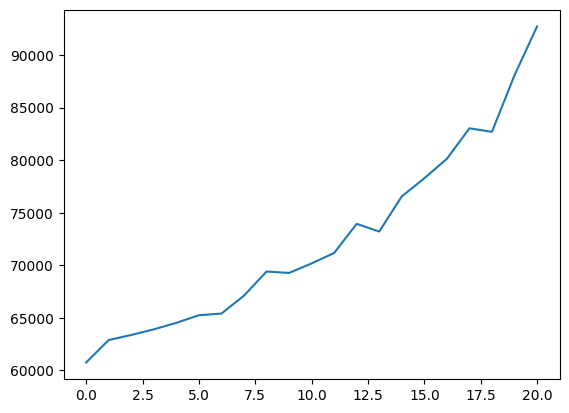

In [55]:
plt.plot(liks_dict_100[500])

In [48]:
r = 100
d = 10

liks_dict_100 = dict()
nr_param_dict_100 = dict()
alphas = np.concatenate(([0], np.logspace(-2,0, 20)))
for n in ns:
    liks = []
    nr_param = []
    for a in range(len(alphas)):
        #psi = Psi_dict_cov[str(r) + '_'+str(d)][k][a]
        #B_tmp = B_dict_cov[str(r) + '_'+str(d)][k][a]
        #nr_param.append(np.sum(np.abs(B_tmp)>1e-3))

        x = Xs_dict[str(r)][:n]
        y = Ys_dict_cov[str(r) + '_'+str(d)][:n]

        cov = cr.CovReg( Y = y, alpha = alphas[a], max_iter = 100, tol = 1e-6)
        cov.fit_hoff_b_only(X2 = x, verbose = False, psi = np.identity(d))
        l, npara = cov.marg_lik(X2 = x)
        liks.append(l)
        nr_param.append(npara)

    liks_dict_100[n] = np.array(liks)
    nr_param_dict_100[n] = np.array(nr_param)

KeyboardInterrupt: 

In [54]:
r = 50
d = 10

liks_dict_50 = dict()
nr_param_dict_50 = dict()
alphas = np.concatenate(([0], np.logspace(-2,0, 20)))
for n in ns:
    liks = []
    nr_param = []
    for a in range(len(alphas)):
        #psi = Psi_dict_cov[str(r) + '_'+str(d)][k][a]
        #B_tmp = B_dict_cov[str(r) + '_'+str(d)][k][a]
        #nr_param.append(np.sum(np.abs(B_tmp)>1e-3))

        x = Xs_dict[str(r)][:n]
        y = Ys_dict_cov[str(r) + '_'+str(d)][:n]

        cov = cr.CovReg( Y = y, alpha = alphas[a], max_iter = 100, tol = 1e-6)
        cov.fit_hoff_b_only(X2 = x, verbose = False)
        l, npara = cov.marg_lik(X2 = x)
        liks.append(l)
        nr_param.append(npara)

    liks_dict_50[n] = np.array(liks)
    nr_param_dict_50[n] = np.array(nr_param)

C:\Users/ragna/Documents/Code/DyGraph/src\CovReg\covreg.py:171: RuntimeWarning: invalid value encountered in scalar divide
  tol_i = np.linalg.norm(C-C_pre)/np.linalg.norm(C_pre)


In [ ]:
r = 20
d = 10

liks_dict_20 = dict()
nr_param_dict_20 = dict()
alphas = np.concatenate(([0], np.logspace(-2,0, 20)))
for n in ns:
    liks = []
    nr_param = []
    for a in range(len(alphas)):
        #psi = Psi_dict_cov[str(r) + '_'+str(d)][k][a]
        #B_tmp = B_dict_cov[str(r) + '_'+str(d)][k][a]
        #nr_param.append(np.sum(np.abs(B_tmp)>1e-3))

        x = Xs_dict[str(r)][:n]
        y = Ys_dict_cov[str(r) + '_'+str(d)][:n]

        cov = cr.CovReg( Y = y, alpha = alphas[a], max_iter = 100, tol = 1e-6)
        cov.fit_hoff_b_only(X2 = x, verbose = False, psi = np.identity(d))
        l, npara = cov.marg_lik(X2 = x)
        liks.append(l)
        nr_param.append(npara)

    liks_dict_20[n] = np.array(liks)
    nr_param_dict_20[n] = np.array(nr_param)

In [58]:
r = 10
d = 10

liks_dict_10 = dict()
nr_param_dict_10 = dict()
alphas = np.concatenate(([0], np.logspace(-2,0, 20)))
for n in ns:
    liks = []
    nr_param = []
    for a in range(len(alphas)):
        #psi = Psi_dict_cov[str(r) + '_'+str(d)][k][a]
        #B_tmp = B_dict_cov[str(r) + '_'+str(d)][k][a]
        #nr_param.append(np.sum(np.abs(B_tmp)>1e-3))

        x = Xs_dict[str(r)][:n]
        y = Ys_dict_cov[str(r) + '_'+str(d)][:n]

        cov = cr.CovReg( Y = y, alpha = alphas[a], max_iter = 100, tol = 1e-6)
        cov.fit_hoff_b_only(X2 = x, verbose = False)
        l, npara = cov.marg_lik(X2 = x)
        liks.append(l)
        nr_param.append(npara)

    liks_dict_10[n] = np.array(liks)
    nr_param_dict_10[n] = np.array(nr_param)

In [59]:
r = 5
d = 10

liks_dict_5 = dict()
nr_param_dict_5 = dict()
alphas = np.concatenate(([0], np.logspace(-2,0, 20)))
for n in ns:
    liks = []
    nr_param = []
    for a in range(len(alphas)):
        #psi = Psi_dict_cov[str(r) + '_'+str(d)][k][a]
        #B_tmp = B_dict_cov[str(r) + '_'+str(d)][k][a]
        #nr_param.append(np.sum(np.abs(B_tmp)>1e-3))

        x = Xs_dict[str(r)][:n]
        y = Ys_dict_cov[str(r) + '_'+str(d)][:n]

        cov = cr.CovReg( Y = y, alpha = alphas[a], max_iter = 100, tol = 1e-6)
        cov.fit_hoff_b_only(X2 = x, verbose = False)
        l, npara = cov.marg_lik(X2 = x)
        liks.append(l)
        nr_param.append(npara)

    liks_dict_5[n] = np.array(liks)
    nr_param_dict_5[n] = np.array(nr_param)

In [34]:
def plot_ic(nr_param, liks, ns):

    fig, ax = plt.subplots(1,3, figsize = (15,5))
    for n in ns:
        ax[0].plot(alphas,(nr_param[n] + liks[n])/np.max(nr_param[n] + liks[n]), label = n)
        ax[1].plot(alphas,-liks[n]/np.max(np.abs(liks[n])), label = n)
        ax[2].plot(alphas,nr_param[n], label = n)


plot_ic(nr_param_dict_100, liks_dict_100, ns)
#plot_ic(nr_param_dict_50, liks_dict_50, ns)
plot_ic(nr_param_dict_20, liks_dict_20, ns)
#plot_ic(nr_param_dict_10, liks_dict_10, ns)
#plot_ic(nr_param_dict_5, liks_dict_5, ns)


NameError: name 'nr_param_dict_100' is not defined

In [27]:
X_tmp = Xs_dict[str(20)]
Y_tmp = Y_meancov['20_10']

cov = cr.CovReg( Y = Y_tmp, alpha = alphas[10], max_iter = 1000, tol = 1e-3)
cov.fit_hoff_b_only(X2 = X_tmp, verbose = False)

In [8]:
print(cov.B[0,:])
print(B_dict_cov['20_10'][2][10][0,:])
print(B_dict_true['20_10'][0,:])

[ 0.03817281 -0.96973342  0.78159217 -1.38798284  0.38062207  1.98705786
  0.83122649 -0.27393128  0.00511562  0.1064922   0.02398483  0.00994861
 -0.07570683 -0.04043651 -0.04051687 -0.02483846 -0.04341337 -0.06822883
  0.00980958 -0.69398925]
[ 0.03014479 -0.86236763  0.72111814 -1.23308112  0.22761168  1.20140144
  0.49716401 -0.30090752  0.023616    0.          0.02758779  0.02113169
  0.00817007 -0.01205592 -0.01394336 -0.04916284 -0.00566186 -0.0231371
  0.         -0.56091589]
[-0.          1.10675862 -0.90772967  1.57616423 -0.28517645 -1.55622133
 -0.68958181  0.35653704  0.         -0.          0.         -0.
  0.          0.          0.          0.00895929 -0.         -0.
 -0.          0.76572087]


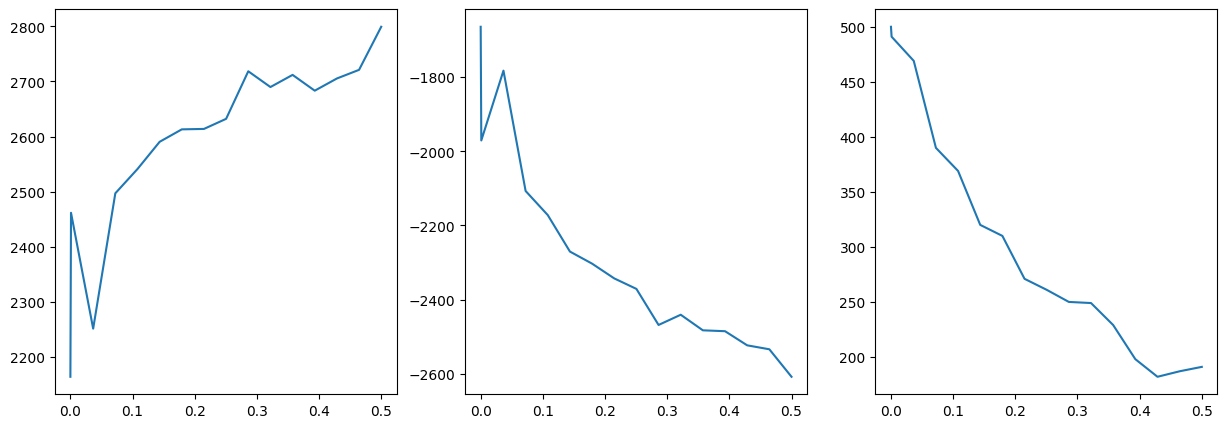

In [43]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
ax[0].plot(alphas,nr_param_dict[100] + liks_dict[100])
ax[1].plot(alphas,-liks_dict[100])
ax[2].plot(alphas,nr_param_dict[100])

# Regularization on True B

## Only B

In [22]:
print(np.round(np.abs(B_dict_true[str(20) + '_'+str(10)][1,:]),2))
print(np.round(np.abs(B_dict_cov[str(20) + '_'+str(10)][3,36][1,:]),2))

[0.72 0.   0.   0.   0.34 1.96 1.66 0.   0.76 0.   0.   0.38 0.   1.09
 0.   0.   0.   0.68 0.   0.9 ]


IndexError: index 3 is out of bounds for axis 0 with size 3

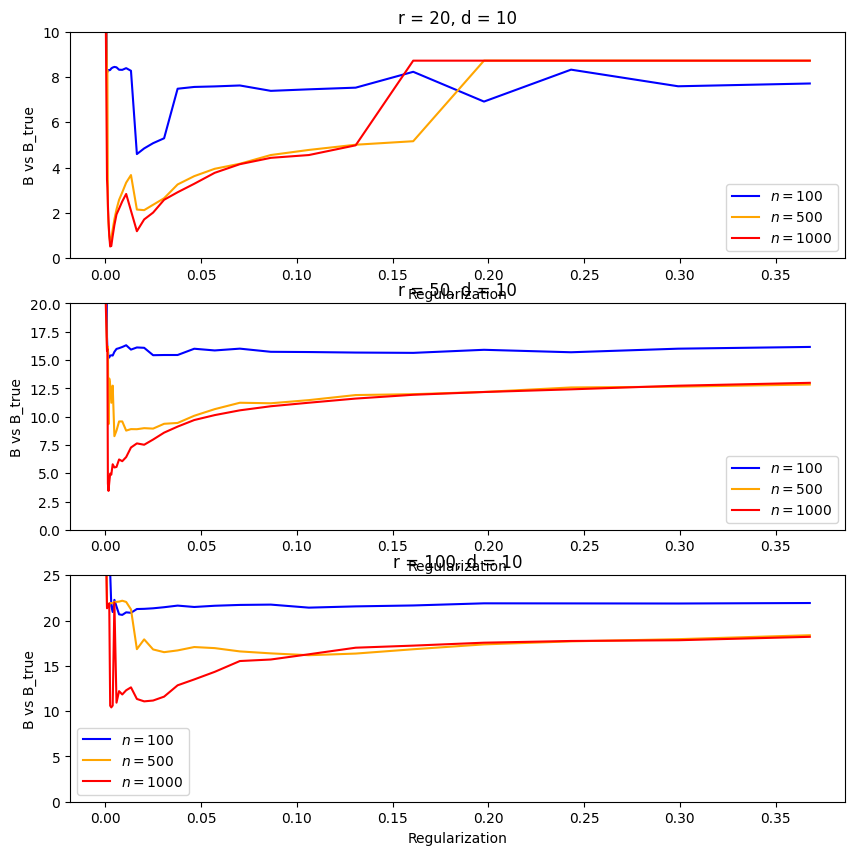

In [9]:
fig, ax = plt.subplots(3,1, figsize = (10,10))

cnt = 0
for r, d in [(20, 10), (50, 10), (100, 10)]:
    for k in range(len(ns)):

        #ax[cnt].plot(alphas, [np.sum(np.abs(np.abs(B_dict_true[str(r) + '_'+str(d)]) - np.abs(B_dict_cov[str(r) + '_'+str(d)][k,i])))/np.sum(np.abs(B_dict_true[str(r) + '_'+str(d)])) for i in range(B_dict_cov[str(r) + '_'+str(d)].shape[1])], label = f'{r"$n = $"}{ns[k]}', color = colors[k])
        ax[cnt].plot(alphas, [np.linalg.norm(np.abs(np.abs(B_dict_true[str(r) + '_'+str(d)]) - np.abs(B_dict_cov[str(r) + '_'+str(d)][k,i]))) for i in range(B_dict_cov[str(r) + '_'+str(d)].shape[1]) ], label = f'{r"$n = $"}{ns[k]}', color = colors[k])
    ax[cnt].legend()
    ax[cnt].set_ylabel("B vs B_true")
    ax[cnt].set_xlabel("Regularization")
    ax[cnt].set_title(f'r = {r}, d = {d}')
    ax[0].set_ylim((0,10))
    ax[1].set_ylim((0,20))
    ax[2].set_ylim((0,25))
    cnt+=1

## B and A

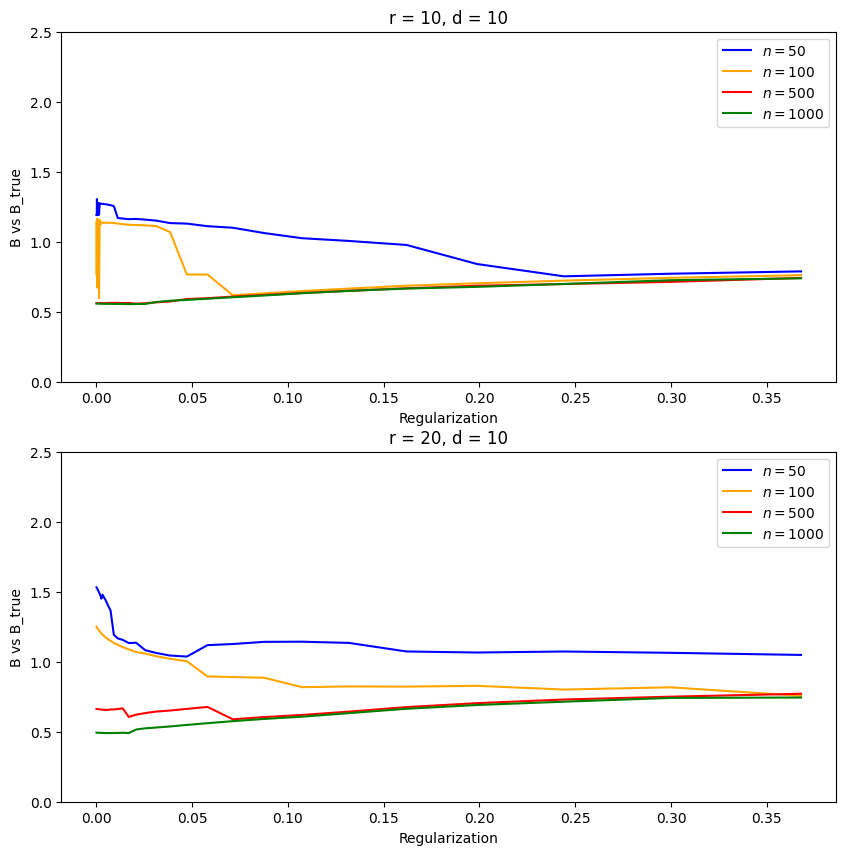

In [6]:
fig, ax = plt.subplots(2,1, figsize = (10,10))

cnt = 0
for r, d in [(10, 10), (20,10)]:
    for k in range(len(ns)):

        ax[cnt].plot(alphas, [np.sum(np.abs(np.abs(B_dict_true[str(r) + '_'+str(d)]) - np.abs(B_dict_meancov[str(r) + '_'+str(d)][k,i])))/np.sum(np.abs(B_dict_true[str(r) + '_'+str(d)])) for i in range(B_dict_meancov[str(r) + '_'+str(d)].shape[1])], label = f'{r"$n = $"}{ns[k]}', color = colors[k])
    ax[cnt].legend()
    ax[cnt].set_ylabel("B vs B_true")
    ax[cnt].set_xlabel("Regularization")
    ax[cnt].set_title(f'r = {r}, d = {d}')
    ax[cnt].set_ylim((0,2.5))
    cnt+=1

# Regularization on AIC

In [27]:


B_dict_true[str(r) + '_'+str(d)].shape

(10, 100)

## only B

In [12]:
nr_param_cov_dict.keys()

dict_keys(['5_10', '10_10', '20_10', '50_10', '100_10'])

In [15]:
nr_param_cov_dict

{'5_10': array([[50., 50., 50., 50., 50., 50., 48., 49., 50., 49., 49., 49., 47.,
         50., 49., 48., 48., 42., 41., 40., 38., 37., 32., 26., 23., 23.,
         17.,  1.,  0.,  0.,  0.],
        [50., 48., 47., 50., 46., 45., 45., 44., 44., 43., 43., 40., 39.,
         37., 34., 34., 32., 28., 25., 26., 24., 22., 20., 18.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.],
        [50., 50., 49., 48., 48., 48., 47., 42., 42., 40., 37., 35., 32.,
         28., 27., 28., 27., 26., 24., 24., 24., 19., 20.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.]]),
 '10_10': array([[100., 100., 100., 100., 100., 100., 100., 100.,  99.,  97.,  97.,
          96.,  96.,  96.,  93.,  91.,  91.,  89.,  91.,  84.,  82.,  83.,
          77.,  67.,  60.,  56.,  52.,  50.,   0.,   0.,   0.],
        [100., 100., 100.,  97.,  96.,  96.,  95.,  95.,  92.,  92.,  92.,
          90.,  88.,  85.,  83.,  82.,  78.,  75.,  72.,  65.,  62.,  62.,
          56.,  54.,  52.,  50.,  49.,  52.,   0.,   0.,   0.],
    

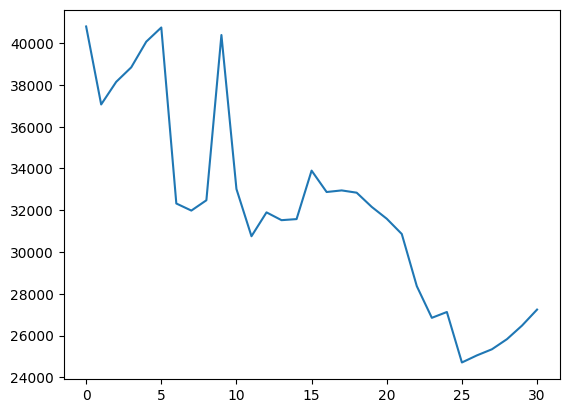

In [20]:
plt.plot(lik_cov_dict['100_10'][2])

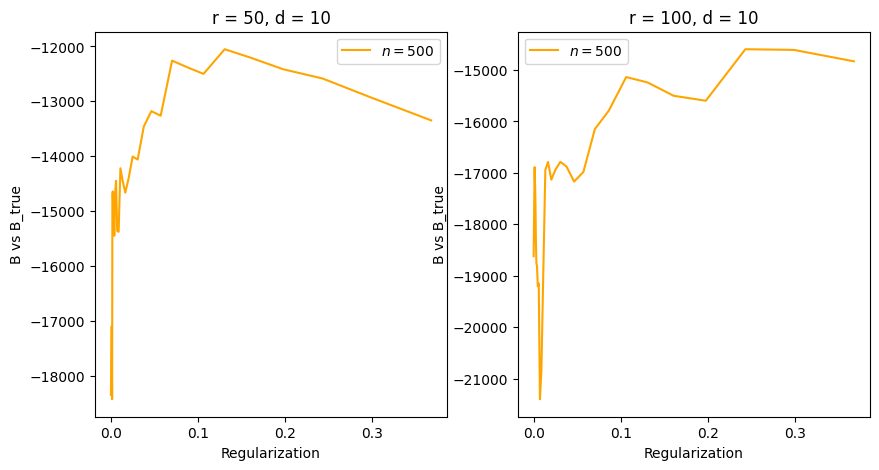

In [21]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
cnt = 0
for r, d in [ (50,10), (100,10)]: #(10, 10), (20,10),
    for k in [1]: #range(len(ns))

        ax[cnt].plot(alphas, nr_param_cov_dict[str(r) + '_'+str(d)][k]-lik_cov_dict[str(r) + '_'+str(d)][k] , label = f'{r"$n = $"}{ns[k]}', color = colors[k])
    ax[cnt].legend()
    ax[cnt].set_ylabel("B vs B_true")
    ax[cnt].set_xlabel("Regularization")
    ax[cnt].set_title(f'r = {r}, d = {d}')
    #ax[cnt].set_ylim((0,2.5))
    cnt+=1

In [10]:
def likelihood(B, X, Y, psi, A = None):
    from scipy.stats import multivariate_normal
    lik = 0.0
    for t in range(X.shape[0]):
        cov = np.dot(B, np.outer(X[t],X[t])).dot(B.T)+ psi
        if A is not None:
            mean = np.dot(A, X[i])
        else:
            mean = None
        
        lik+= multivariate_normal.logpdf(Y[t], cov = cov, mean = mean, allow_singular = True)

    return lik

In [24]:
B_dict_cov[str(r) + '_'+str(d)][0].shape
Xs_dict = shap_data['Xs_dict']
Y_cov = shap_data['Ys_dict_cov']

(31, 10, 100)

In [46]:
lik_vec = []
lik_vec_psi = []

nr_param_vec = []
nr_param_vec_psi = []

r = 100
d = 10
n_idx = 3
Psi_dict_cov = shap_data['Psi_dict_cov']
for a_idx  in range(len(alphas)):
    print(a_idx)
    B = B_dict_cov[str(r) + '_'+str(d)][n_idx][a_idx].copy()
    B_psi = B_dict_cov_psi[str(r) + '_'+str(d)][n_idx][a_idx].copy()
    psi = Psi_dict_cov[str(r) + '_'+str(d)][n_idx][a_idx].copy()
    psi_true = np.identity(d)
    X = Xs_dict[str(r)][n_idx].copy()
    Y = Y_cov[str(r) + '_'+str(d)][n_idx].copy()

    lik_vec_psi.append(likelihood(B_psi, X, Y, psi_true))
    lik_vec.append(likelihood(B, X, Y, psi))

    nr_param_vec_psi.append(np.sum(np.abs(B_psi)>1e-3))
    nr_param_vec.append(np.sum(np.abs(B)>1e-3))






0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [5]:
r = 100
d = 10
lik_vec_psi = np.zeros(len(alphas))
nr_param_vec_psi = np.zeros(len(alphas))
for a_idx, alpha in enumerate(alphas):
    Y_tmp = Y_cov[str(r) + '_'+str(d)][3].copy()
    X_tmp = Xs_dict[str(r)][3].copy()
    cov = cr.CovReg( Y = Y_tmp, alpha = alpha, max_iter = 1000, tol = 1e-3)
    cov.fit_hoff_b_only(X2 = X_tmp, psi = np.identity(d), verbose = True)

    lik_vec_psi[a_idx], nr_param_vec_psi[a_idx] = cov.marg_lik(X1 = None, X2 = X_tmp)

    #lik_vec_psi.append(likelihood(cov.B, X_tmp, Y_tmp, np.identity(d)))

  0%|          | 0/1000 [00:00<?, ?it/s]

Error 4.88E-4:   2%|▏         | 20/1000 [00:03<02:37,  6.21it/s]


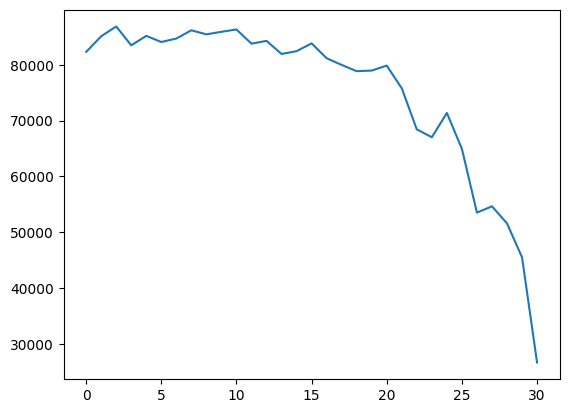

In [17]:
plt.plot(lik_vec_psi)

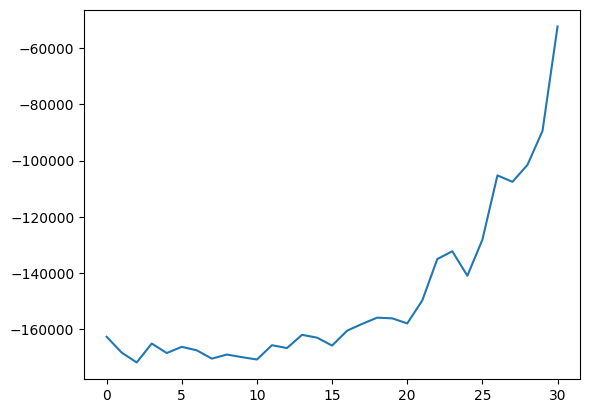

In [11]:
plt.plot(nr_param_vec_psi*2-2*lik_vec_psi)

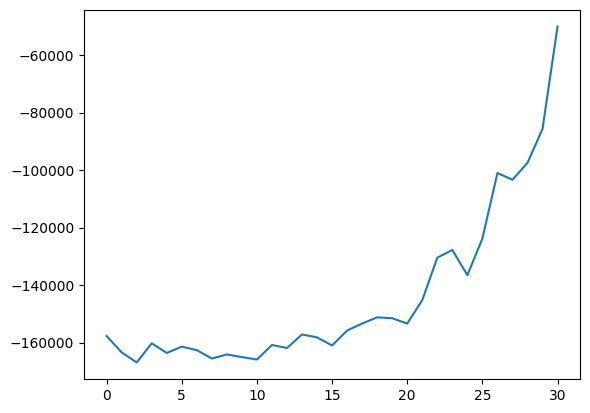

In [9]:
plt.plot(nr_param_vec_psi*np.log(1000)-2*lik_vec_psi)

In [10]:
r = 100
d = 10
lik_vec = np.zeros(len(alphas))
nr_param_vec = np.zeros(len(alphas))
for a_idx, alpha in enumerate(alphas):
    Y_tmp = Y_cov[str(r) + '_'+str(d)][3].copy()
    X_tmp = Xs_dict[str(r)][3].copy()
    cov = cr.CovReg( Y = Y_tmp, alpha = alpha, max_iter = 200, tol = 1e-3)
    cov.fit_hoff_b_only(X2 = X_tmp, verbose = True)

    lik_vec[a_idx], nr_param_vec[a_idx] = cov.marg_lik(X1 = None, X2 = X_tmp)

    #lik_vec_psi.append(likelihood(cov.B, X_tmp, Y_tmp, np.identity(d)))

  0%|          | 0/200 [00:00<?, ?it/s]

Error 1.00E+4: 100%|██████████| 200/200 [00:14<00:00, 13.59it/s]


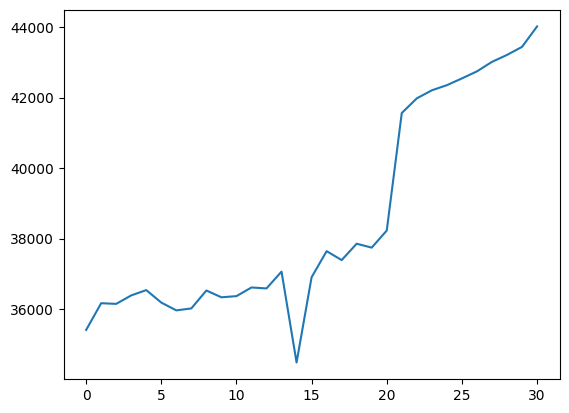

In [11]:
plt.plot(lik_vec)

In [13]:
nr_param_vec

array([1000., 1000., 1000., 1000., 1000.,  999., 1000., 1000., 1000.,
       1000., 1000., 1000.,  998.,  999.,  949.,  999.,  997.,  994.,
        993.,  995.,  986.,  769.,  656.,  576.,  527.,  485.,  458.,
        366.,  292.,  195.,   13.])

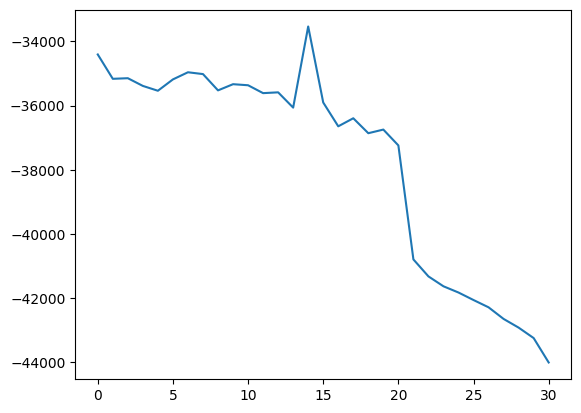

In [12]:
plt.plot(nr_param_vec-lik_vec)

In [57]:
np.round(cov.B[0,:],2)

array([ 0.03, -0.21,  0.16, -0.33, -0.11, -0.54,  0.2 , -0.54, -0.11,
       -0.25, -0.18,  0.24,  0.29, -0.11,  0.31,  0.21, -0.18, -0.21,
       -0.42,  0.15, -0.07,  0.24, -0.36, -0.05,  0.08, -0.27,  0.43,
       -0.02, -0.15,  0.09,  0.18, -0.01,  0.15,  0.05, -0.38, -0.01,
       -0.01,  0.24, -0.29,  0.  ,  0.03,  0.33, -0.83, -0.35, -0.37,
        0.02,  0.13,  0.24, -0.24, -0.02,  0.59,  0.95, -0.01, -0.15,
        0.07,  0.43, -0.06,  0.08,  0.  , -0.15, -0.41, -0.32,  0.11,
        0.06, -0.09,  0.25, -0.  ,  0.17,  0.48, -0.03, -0.21,  0.13,
        0.29, -0.01, -0.39, -0.14, -0.21,  0.42, -0.24, -0.28, -0.84,
       -0.06,  0.05,  0.2 , -0.07,  0.19,  0.28, -0.2 ,  0.11,  0.25,
       -0.11,  0.13,  0.25,  0.14,  0.28,  0.4 , -0.28, -0.07,  0.06,
        0.17])

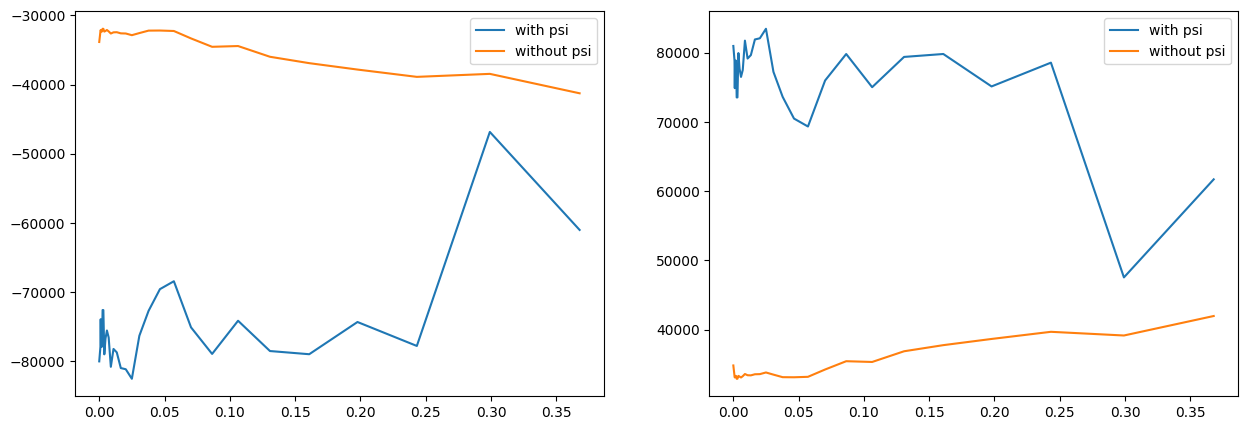

In [51]:
fig, ax = plt.subplots(1,2, figsize = (15,5))

ax[0].plot(alphas, lik_vec_psi, label = 'with psi')
ax[0].plot(alphas, lik_vec, label = 'without psi')
ax[0].legend()

ax[1].plot(alphas, np.array(nr_param_vec_psi)-np.array(lik_vec_psi), label = 'with psi')
ax[1].plot(alphas, np.array(nr_param_vec) - np.array(lik_vec), label = 'without psi')
ax[1].legend()

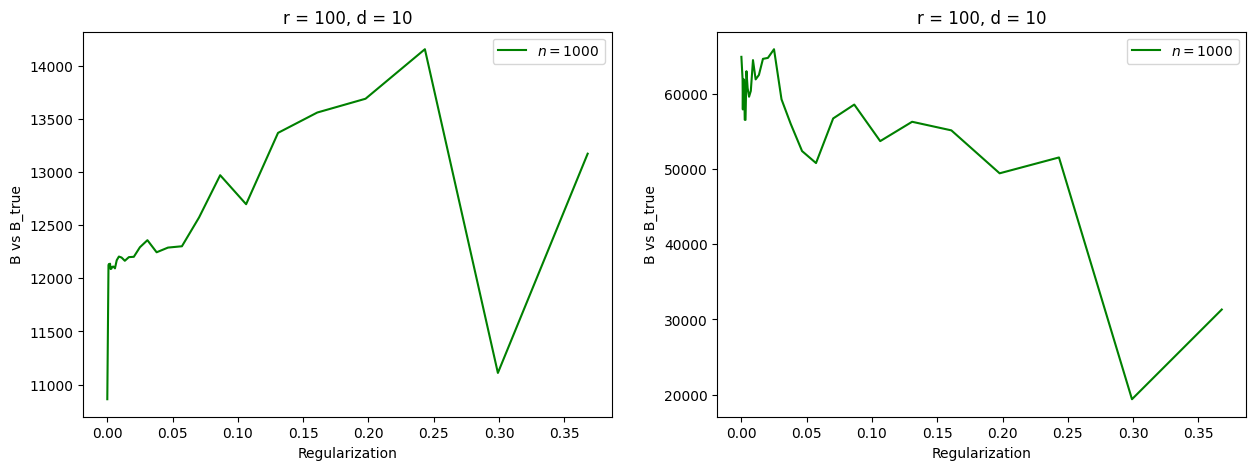

In [21]:
fig, ax = plt.subplots(1,2, figsize = (15,5))

cnt = 0
for r, d in [(100,10)]:

    ax[0].plot(alphas,nr_param_cov_dict[str(r) + '_'+str(d)][3]+lik_cov_dict[str(r) + '_'+str(d)][3], label = f'{r"$n = $"}{ns[k]}', color = colors[k])
    ax[0].legend()
    ax[0].set_ylabel("B vs B_true")
    ax[0].set_xlabel("Regularization")
    ax[0].set_title(f'r = {r}, d = {d}')


    ax[1].plot(alphas,nr_param_cov_psi_dict[str(r) + '_'+str(d)][3]+lik_cov_psi_dict[str(r) + '_'+str(d)][3], label = f'{r"$n = $"}{ns[k]}', color = colors[k])
    ax[1].legend()
    ax[1].set_ylabel("B vs B_true")
    ax[1].set_xlabel("Regularization")
    ax[1].set_title(f'r = {r}, d = {d}')
    #ax[1].set_ylim((4000, 8000))

# Temporal Shapley experiment

In [2]:
from sklearn.datasets import make_sparse_spd_matrix
rnd = np.random.RandomState(2)
r = 12
R = make_sparse_spd_matrix(dim=r, alpha = 0.5,random_state=42,norm_diag=True)
#print(R)

alpha_1 = 0.1*rnd.uniform(size = R.shape[0] )
#alpha_1[2] = 0
#alpha_1[3] = 0
alpha_0 = 1
beta_1 = 0.1
print(beta_1 + np.dot(alpha_1, R).dot(alpha_1))
assert beta_1 + np.dot(alpha_1, R).dot(alpha_1)<1

# Generate a path
T = 100
x = []
sigmas = np.zeros(T+1)
sigmas[0] = 1.12
x = np.zeros((T,r))
for i in range(T):
    x[i] = rnd.multivariate_normal(mean = np.zeros(R.shape[0]), cov = R*sigmas[i])
    sigmas[i+1] = alpha_0 + np.dot(alpha_1, np.outer(x[i],x[i])).dot(alpha_1) + beta_1*sigmas[i]


d = 12
gamma = rnd.normal(loc = 0, scale = 1, size = (T))
epsilon = rnd.normal(loc = 0, scale = 1, size = (T,d))
B_true = rnd.normal(loc = 0, scale = 1, size = (d,r))
B_true =B_true*(rnd.uniform(size = (d,r) ) <0.3)


#Y = gamma[:, np.newaxis]*np.dot(x, B_true.T) + epsilon






const = beta_1 + np.dot(alpha_1, R).dot(alpha_1)
uncond_cov = R*alpha_0/(1-const)

uncond_shap = calc_shapley_value(B_true,x, Sigma = uncond_cov)


cond_shap = np.zeros((T, int(d*(d+1)/2), r))
cond_cov = np.zeros((T,r,r))
for t in range(T):
    cond_cov[t] = R*sigmas[t]
    cond_shap[t] = calc_shapley_value(B_true, x, Sigma = cond_cov[t])





val_y = np.dot(B_true, uncond_cov).dot(B_true.T)



0.11419093260990426


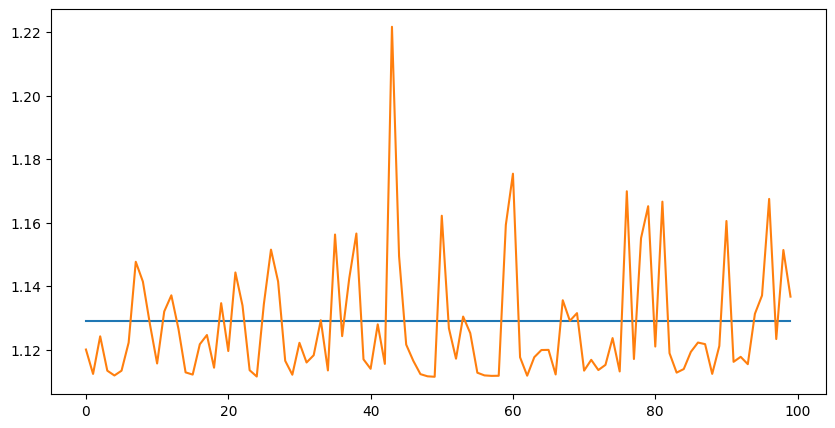

In [3]:
node_idx = 1
fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.plot(range(T), [uncond_cov[node_idx, node_idx]]*T)
# ax.plot(range(T), [uncond_cov[0, 0]]*T)
ax.plot(range(T), cond_cov[:,node_idx,node_idx])

Single element Shapley for one node

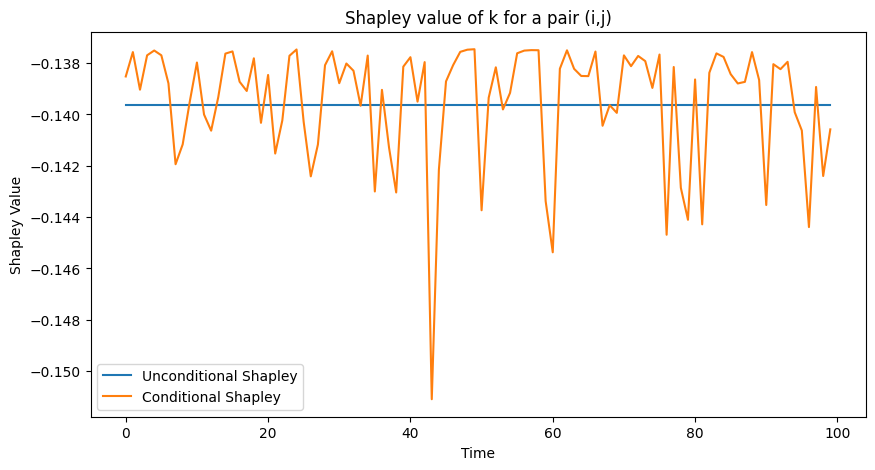

In [19]:
ij = 3
node_idx = 1
fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(range(T), [uncond_shap[ij, node_idx]]*T, label = "Unconditional Shapley")
ax.plot(range(T), cond_shap[:, ij, node_idx], label = "Conditional Shapley")
ax.set_ylabel("Shapley Value")
ax.set_xlabel("Time")
ax.set_title("Shapley value of k for a pair (i,j)")
ax.legend()

Aggregated Shapley for one node

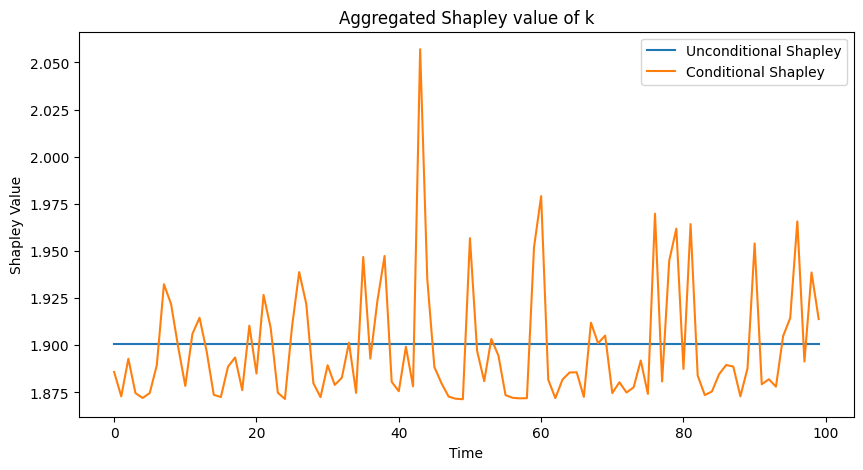

In [20]:
ij = 3
node_idx = 1
fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(range(T), [np.sum(uncond_shap[:, node_idx], 0)]*T, label = "Unconditional Shapley")
ax.plot(range(T), np.sum(cond_shap[:, :, node_idx], 1), label = "Conditional Shapley")
ax.set_ylabel("Shapley Value")
ax.set_xlabel("Time")
ax.set_title("Aggregated Shapley value of k")
ax.legend()

Do the same but for GGP

3.320116922736544
[[ 0.57911865 -0.26683564  0.86157456  0.44865749  1.03810521  0.95400861]
 [ 0.47819302 -0.17859233  0.78967343  0.37724512  1.08691968  0.66853651]
 [ 0.43805654 -0.13236456  0.72426918  0.32612877  1.11627118  0.54408166]
 [ 0.43006902 -0.12177805  0.61492305  0.34734373  1.10681598  0.31074908]
 [ 0.41232757 -0.16114719  0.49255184  0.33459281  1.10713083  0.18317802]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[-0.66809045  0.99204235 -0.17495976 -0.75574516  0.53650984 -0.89846798]
 [ 0.02818116 -0.009119    1.08589557  0.47469823 -0.02502696  0.8177663 ]]
[ 0.1252245  -0.42940554]


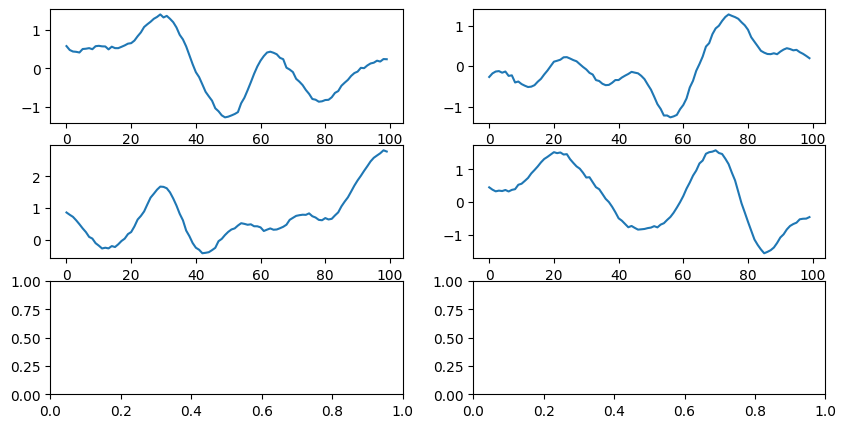

In [18]:
rnd = np.random.RandomState(42)


n = 100
d = 6
r = 6
X = rnd.normal(loc = 0, scale = 1, size = (n,r))


G = nx.fast_gnp_random_graph(r, 3/r,    seed = 1)

v, u = np.linalg.eigh(nx.laplacian_matrix(G).todense())

H = np.array(np.dot(u, np.diag(np.exp(-0.1*v))).dot(u.T))
print(np.linalg.cond(np.dot(H,H)))


#T  = np.random.normal(loc = 0, scale = 1, size = (n,r)) 
T = np.linspace(1,10,n).reshape(-1,1)
K = rbf_kernel(T,T, gamma = 1) + 0.001*np.identity(n)
# print(K[:,0])

omega = 1
matrix_normal.random_state = rnd
F_true = matrix_normal.rvs(np.zeros((n,r)), rowcov = K, colcov = np.dot(H,H)*(1/omega) )
H_sq  = np.dot(H,H)

scale = 1
psi = scale*np.identity(d)
psi_inv = np.linalg.inv(psi)

gamma = rnd.normal(loc = 0, scale = 1, size = (n))
epsilon= rnd.normal(loc = 0, scale = scale, size = (n,d))
#B_true = np.random.normal(loc = 0, scale = 0, size = (d,r))
#A_true = np.random.normal(loc = 0, scale = 0, size = (d,r))
P = rnd.binomial(1,0.5,size = (d,r) )
#A_true = rnd.uniform(0.5,1,size = (d,r))*P + np.random.uniform(-1,-0.5,size = (d,r))*(1-P)
B_true = rnd.uniform(-1,1,size = (d,r))#*0
B_true[np.abs(B_true)<0.5] = 0#*(np.random.uniform(size = (d,r) ) <0.5)
A_true = np.zeros((d,r))# A_true*(rnd.uniform(size = (d,r) ) <0.5)

Y = np.dot(F_true, A_true.T) +  gamma[:, np.newaxis]*np.dot(F_true, B_true.T) + epsilon

fig, ax = plt.subplots(3,2, figsize = (10,5))
ax[0,0].plot(F_true[:,0])
ax[0,1].plot(F_true[:,1])
ax[1,0].plot(F_true[:,2])
ax[1,1].plot(F_true[:,3])
#ax[2,0].plot(F_true[:,4])
#ax[2,1].plot(F_true[:,5])
#ax.plot(multivariate_normal.rvs(cov = rbf_kernel(np.linspace(1,10,100).reshape(-1,1),np.linspace(1,10,100).reshape(-1,1), gamma = 0.1)))

print(F_true[:5,:])
print(A_true[:2,:2])
print(B_true[:2,:2])
print(epsilon[:2])
print(gamma[:2])

In [44]:
B_true.shape

(6, 6)

In [50]:
np.array([K[t,s] for s in range(t)]).reshape((t,1))

array([[6.63967720e-36],
       [3.38237264e-35],
       [1.69479635e-34],
       [8.35285925e-34],
       [4.04924810e-33],
       [1.93079066e-32],
       [9.05560708e-32],
       [4.17754879e-31],
       [1.89560161e-30],
       [8.46046409e-30],
       [3.71417945e-29],
       [1.60381089e-28],
       [6.81184900e-28],
       [2.84576114e-27],
       [1.16937406e-26],
       [4.72639536e-26],
       [1.87900621e-25],
       [7.34764160e-25],
       [2.82611149e-24],
       [1.06918337e-23],
       [3.97865866e-23],
       [1.45627282e-22],
       [5.24288566e-22],
       [1.85660539e-21],
       [6.46681456e-21],
       [2.21555628e-20],
       [7.46615056e-20],
       [2.47475539e-19],
       [8.06843667e-19],
       [2.58742690e-18],
       [8.16146948e-18],
       [2.53215457e-17],
       [7.72740443e-17],
       [2.31952283e-16],
       [6.84833883e-16],
       [1.98881051e-15],
       [5.68097858e-15],
       [1.59615284e-14],
       [4.41110483e-14],
       [1.19906261e-13],


In [59]:
uncond_cov_gp = H_sq

uncond_shap_gp = calc_shapley_value(B_true,x, Sigma = uncond_cov_gp)


cond_shap_gp = np.zeros((n, int(d*(d+1)/2), r))
cond_cov_gp = np.zeros((n,r,r))
for t in range(1,n):
    k = np.array([K[t,s] for s in range(t)]).reshape((t,1))

    D = np.kron(H_sq,k)
    C = np.linalg.inv(np.kron(H_sq, K[:t, :t]))
    cov = K[t,t]*H_sq - np.dot(D.T, C).dot(D)
    mean = np.dot(np.kron(H_sq,k).T, F_true[:t,].flatten(order = 'F'))
    cond_cov_gp[t] = cov + np.outer(mean, mean)
    cond_shap_gp[t] = calc_shapley_value(B_true, None, Sigma = cond_cov_gp[t])





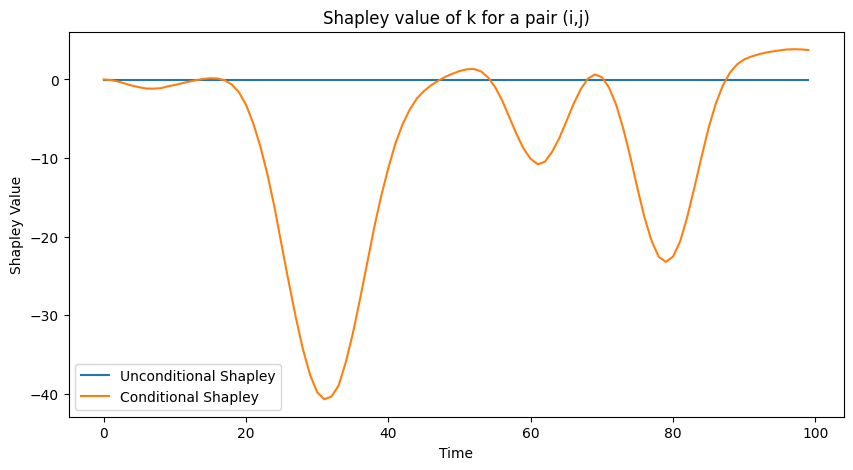

In [61]:
ij = 3
node_idx = 1
fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(range(n), [uncond_shap_gp[ij, node_idx]]*n, label = "Unconditional Shapley")
ax.plot(range(n), cond_shap_gp[:, ij, node_idx], label = "Conditional Shapley")
ax.set_ylabel("Shapley Value")
ax.set_xlabel("Time")
ax.set_title("Shapley value of k for a pair (i,j)")
ax.legend()